# Tuning Neural Networks with Regularization - Lab 

## Introduction

In this lab, you'll use a train-test partition as well as a validation set to get better insights about how to tune neural networks using regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. From there, you'll define and compile the model like before. 

## Objectives

You will be able to:

- Apply early stopping criteria with a neural network 
- Apply L1, L2, and dropout regularization on a neural network  
- Examine the effects of training with more data on a neural network  


## Load the Data

Run the following cell to import some of the libraries and classes you'll need in this lab. 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

The data is stored in the file `'Bank_complaints.csv'`. Load and preview the dataset.

In [2]:
# Load and preview the dataset
df = pd.read_csv('Bank_complaints.csv')
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Preprocessing Overview

Before you begin to practice some of your new tools such as regularization and optimization, let's practice munging some data as you did in the previous section with bank complaints. Recall some techniques:

* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* Train - test split
* One-hot encoding your complaint text
* Transforming your category labels 

## Preprocessing: Generate a Random Sample

Since you have quite a bit of data and training neural networks takes a substantial amount of time and resources, downsample in order to test your initial pipeline. Going forward, these can be interesting areas of investigation: how does your model's performance change as you increase (or decrease) the size of your dataset?  

- Generate a random sample of 10,000 observations using seed 123 for consistency of results. 
- Split this sample into `X` and `y` 

In [3]:
# Downsample the data
df_sample = df.sample(10000, random_state=123)

# Split the data into X and y
y = df_sample['Product']
X = df_sample['Consumer complaint narrative']

## Train-test split

- Split the data into training and test sets 
- Assign 1500 obervations to the test set and use 42 as the seed 

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1500,random_state=42)

## Validation set 

As mentioned in the previous lesson, it is good practice to set aside a validation set, which is then used during hyperparameter tuning. Afterwards, when you have decided upon a final model, the test set can then be used to determine an unbiased perforance of the model. 

Run the cell below to further divide the training data into training and validation sets. 

In [5]:
# Split the data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=1000, random_state=42)

## Preprocessing: One-hot Encoding the Complaints

As before, you need to do some preprocessing before building a neural network model. 

- Keep the 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors 
- Transform the training, validate, and test sets 

In [18]:
# Use one-hot encoding to reformat the complaints into a matrix of vectors 
# Only keep the 2000 most common words 

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final)

X_train_tokens = tokenizer.texts_to_matrix(X_train_final, mode = 'binary')
X_val_tokens = tokenizer.texts_to_matrix(X_val, mode = 'binary')
X_test_tokens = tokenizer.texts_to_matrix(X_test, mode = 'binary')



## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
> **Note**: This is similar to your previous work with dummy variables. Each of the various product categories will be its own column, and each observation will be a row. In turn, each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero. 

Transform the training, validate, and test sets. 

In [17]:
# Transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train_final)

y_train_lb = to_categorical(lb.transform(y_train_final))[:,:,1]
y_val_lb = to_categorical(lb.transform(y_val))[:,:,1]
y_test_lb = to_categorical(lb.transform(y_test))[:,:,1]



## A Baseline Model 

Rebuild a fully connected (Dense) layer network:  
- Use 2 hidden layers with 50 units in the first and 25 in the second layer, both with `'relu'` activation functions (since you are dealing with a multiclass problem, classifying the complaints into 7 classes) 
- Use a `'softmax'` activation function for the output layer  

In [19]:
# Build a baseline neural network model using Keras
random.seed(123)
from keras import models
from keras import layers
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(50, activation = 'relu', input_shape = (2000,)))
baseline_model.add(layers.Dense(25, activation='relu'))
baseline_model.add(layers.Dense(7, activation = 'softmax'))



c:\Users\user\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the Model

Compile this model with: 

- a stochastic gradient descent optimizer 
- `'categorical_crossentropy'` as the loss function 
- a focus on `'accuracy'` 

In [20]:
# Compile the model
baseline_model.compile(optimizer='SGD', loss = 'categorical_crossentropy', metrics=['acc'])

### Train the Model

- Train the model for 150 epochs in mini-batches of 256 samples 
- Include the `validation_data` argument to ensure you keep track of the validation loss  

In [21]:
# Train the model
baseline_model_val = baseline_model.fit(X_train_tokens,
                                        y_train_lb,
                                        epochs=150,
                                        batch_size=256,
                                        validation_data=(X_val_tokens,y_val_lb))

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.1273 - loss: 1.9595 - val_acc: 0.1480 - val_loss: 1.9546
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.1649 - loss: 1.9418 - val_acc: 0.1860 - val_loss: 1.9399
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.2059 - loss: 1.9269 - val_acc: 0.2120 - val_loss: 1.9262
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2351 - loss: 1.9114 - val_acc: 0.2420 - val_loss: 1.9108
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2609 - loss: 1.8925 - val_acc: 0.2750 - val_loss: 1.8921
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2797 - loss: 1.8712 - val_acc: 0.2880 - val_loss: 1.8705
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2986 - loss: 1.8497 - val_acc: 0.3140 - val_loss: 1.8446
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3246 - loss: 1.8219 - val_acc: 0.3290 - val_loss: 1.8138
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.346

### Model Performance

The attribute `.history` (stored as a dictionary) contains four entries now: one per metric that was being monitored during training and validation. Print the keys of this dictionary for confirmation: 

In [23]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = baseline_model_val.history

# Print the keys
baseline_model_val_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

Evaluate this model on the training data: 

In [25]:
results_train = baseline_model.evaluate(X_train_tokens,y_train_lb)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9144 - loss: 0.2944
----------
Training Loss: 0.296 
Training Accuracy: 0.912


Evaluate this model on the test data: 

In [26]:
results_test = baseline_model.evaluate(X_test_tokens,y_test_lb)
print('----------')
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7967 - loss: 0.5894
----------
Test Loss: 0.61 
Test Accuracy: 0.791


### Plot the Results 

Plot the loss versus the number of epochs. Be sure to include the training and the validation loss in the same plot. 

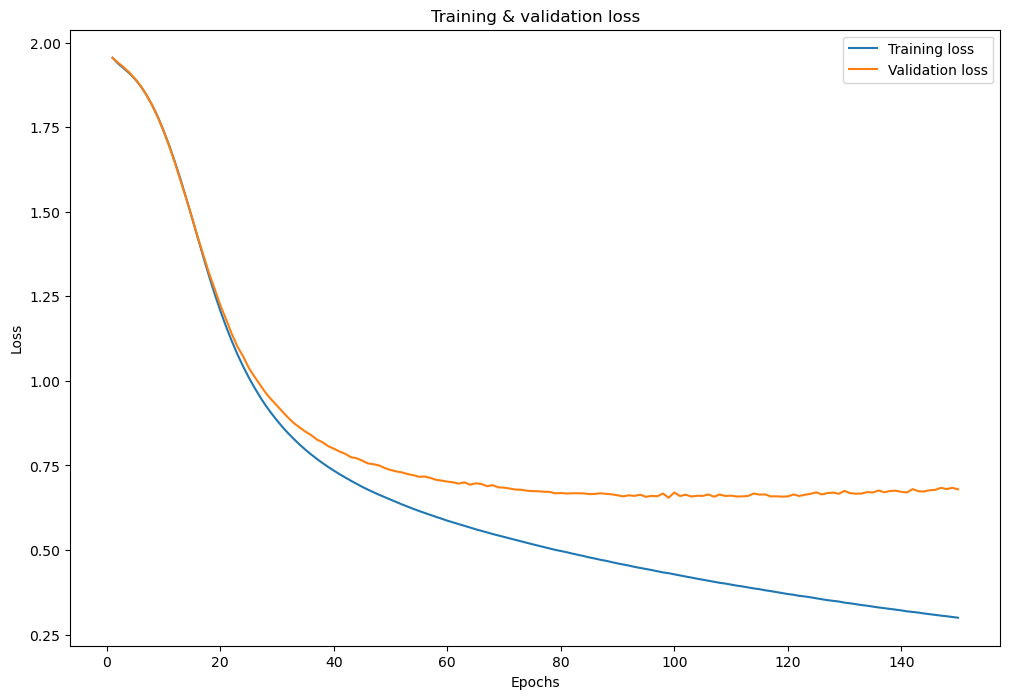

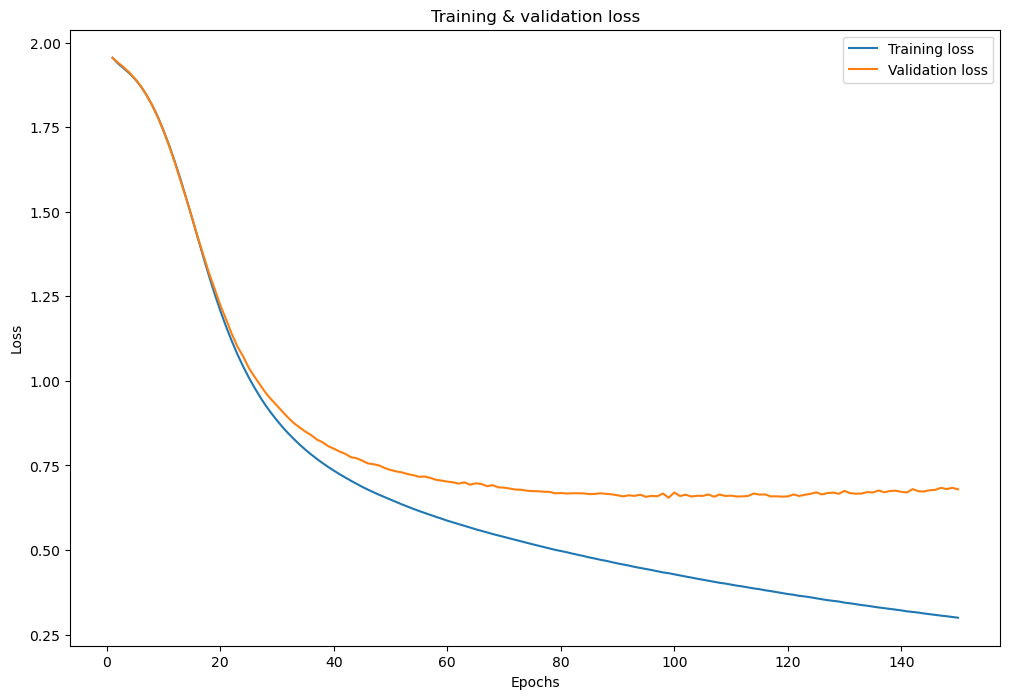

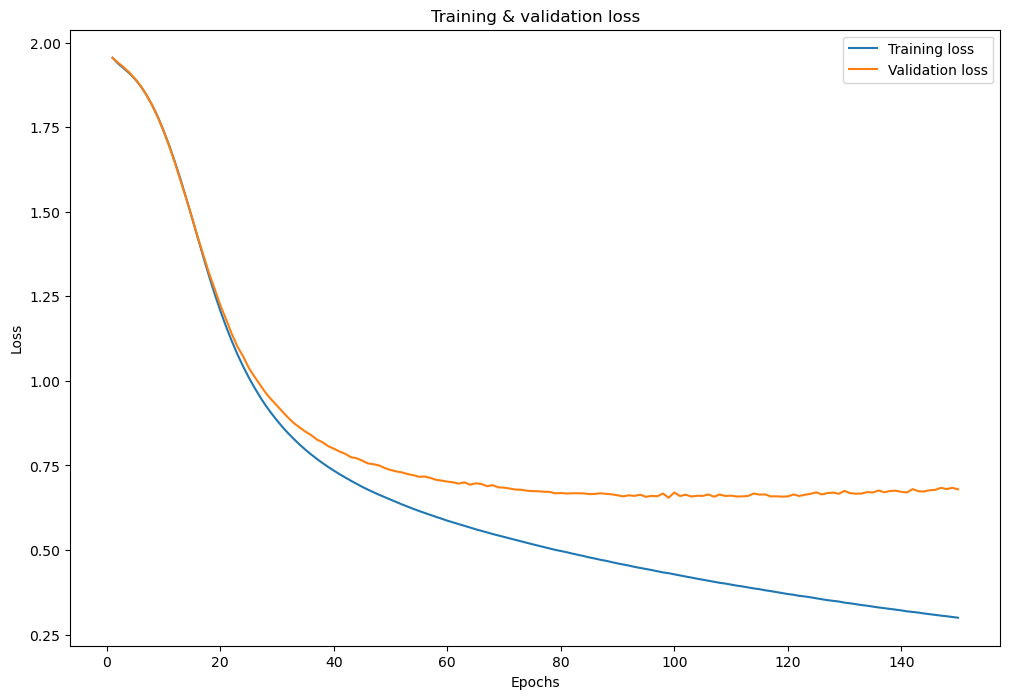

In [29]:
# Loss vs number of epochs with train and validation sets
fig, ax = plt.subplots(figsize=(12, 8))

loss_values = baseline_model_val_dict['loss']
val_loss_values = baseline_model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show();

Create a second plot comparing training and validation accuracy to the number of epochs. 

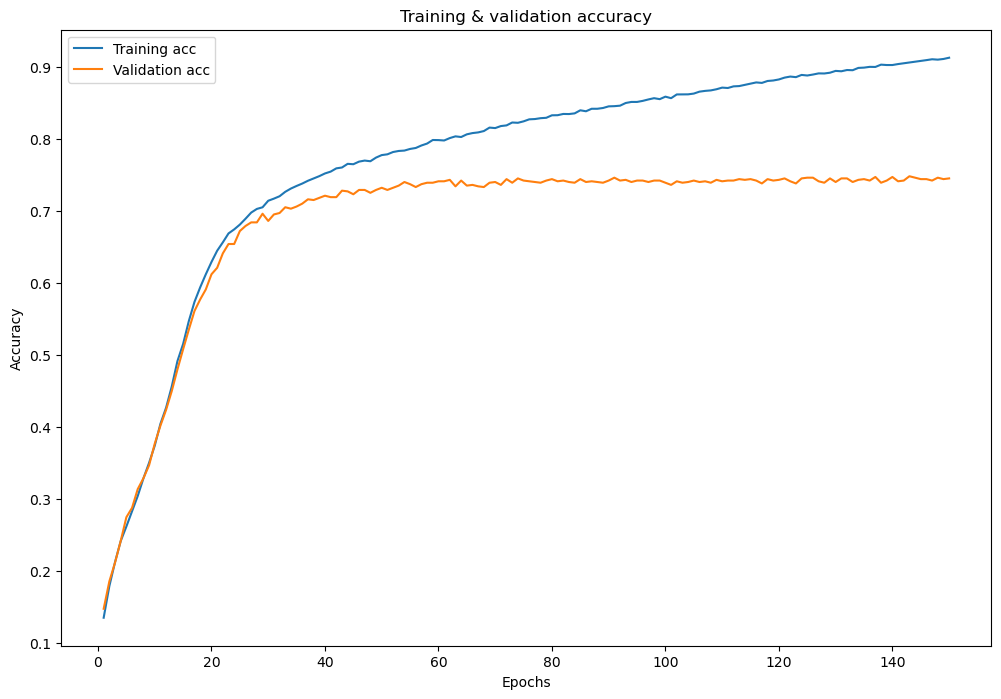

In [30]:
# Accuracy vs number of epochs with train and validation sets
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = baseline_model_val_dict['acc'] 
val_acc_values = baseline_model_val_dict['val_acc']

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show();

Did you notice an interesting pattern here? Although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss don't necessarily do the same. After a certain point, validation accuracy keeps swinging, which means that you're probably **overfitting** the model to the training data when you train for many epochs past a certain dropoff point. Let's tackle this now. You will now specify an early stopping point when training your model. 


## Early Stopping

Overfitting neural networks is something you **_want_** to avoid at all costs. However, it's not possible to know in advance how many *epochs* you need to train your model on, and running the model multiple times with varying number of *epochs* maybe helpful, but is a time-consuming process. 

We've defined a model with the same architecture as above. This time specify an early stopping point when training the model. 

In [31]:
random.seed(123)
model_2 = models.Sequential()
model_2.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
model_2.add(layers.Dense(25, activation='relu'))
model_2.add(layers.Dense(7, activation='softmax'))

model_2.compile(optimizer='SGD', 
                loss='categorical_crossentropy', 
                metrics=['acc'])

c:\Users\user\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- Import `EarlyStopping` and `ModelCheckpoint` from `keras.callbacks` 
- Define a list, `early_stopping`: 
  - Monitor `'val_loss'` and continue training for 10 epochs before stopping 
  - Save the best model while monitoring `'val_loss'` 
 
> If you need help, consult [documentation](https://keras.io/callbacks/).   

In [32]:
# Import EarlyStopping and ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

Train `model_2`. Make sure you set the `callbacks` argument to `early_stopping`. 

In [33]:
model_2_val = model_2.fit(X_train_tokens, 
                          y_train_lb, 
                          epochs=150, 
                          callbacks=early_stopping, 
                          batch_size=256, 
                          validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.1306 - loss: 1.9614  

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.1311 - loss: 1.9608 - val_acc: 0.1500 - val_loss: 1.9547
Epoch 2/150
15/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.1746 - loss: 1.9411 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.1764 - loss: 1.9396 - val_acc: 0.1860 - val_loss: 1.9403
Epoch 3/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2008 - loss: 1.9282

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2017 - loss: 1.9279 - val_acc: 0.2150 - val_loss: 1.9263
Epoch 4/150
15/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2345 - loss: 1.9137 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2374 - loss: 1.9120 - val_acc: 0.2440 - val_loss: 1.9108
Epoch 5/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2609 - loss: 1.8922

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2609 - loss: 1.8921 - val_acc: 0.2690 - val_loss: 1.8922
Epoch 6/150
15/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2789 - loss: 1.8803 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2805 - loss: 1.8764 - val_acc: 0.2930 - val_loss: 1.8705
Epoch 7/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2995 - loss: 1.8509

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3000 - loss: 1.8503 - val_acc: 0.3090 - val_loss: 1.8444
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.3216 - loss: 1.8215

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3218 - loss: 1.8213 - val_acc: 0.3220 - val_loss: 1.8139
Epoch 9/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.3381 - loss: 1.7894

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3398 - loss: 1.7877 - val_acc: 0.3450 - val_loss: 1.7782
Epoch 10/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.3763 - loss: 1.7477

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3764 - loss: 1.7472 - val_acc: 0.3790 - val_loss: 1.7379
Epoch 11/150
24/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3893 - loss: 1.7136 

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3920 - loss: 1.7097 - val_acc: 0.4040 - val_loss: 1.6939
Epoch 12/150
20/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.4284 - loss: 1.6544 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.4289 - loss: 1.6523 - val_acc: 0.4330 - val_loss: 1.6442
Epoch 13/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4464 - loss: 1.6095

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.4497 - loss: 1.6068 - val_acc: 0.4600 - val_loss: 1.5928
Epoch 14/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.4795 - loss: 1.5487

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4798 - loss: 1.5484 - val_acc: 0.4880 - val_loss: 1.5381
Epoch 15/150
24/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.5138 - loss: 1.5027

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5152 - loss: 1.4986 - val_acc: 0.5020 - val_loss: 1.4831
Epoch 16/150
18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5321 - loss: 1.4432

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5363 - loss: 1.4367 - val_acc: 0.5340 - val_loss: 1.4253
Epoch 17/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.5568 - loss: 1.3860

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5583 - loss: 1.3842 - val_acc: 0.5510 - val_loss: 1.3747
Epoch 18/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.5846 - loss: 1.3340

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5854 - loss: 1.3318 - val_acc: 0.5810 - val_loss: 1.3215
Epoch 19/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6054 - loss: 1.2832

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6059 - loss: 1.2808 - val_acc: 0.5920 - val_loss: 1.2690
Epoch 20/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6235 - loss: 1.2161

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6238 - loss: 1.2153 - val_acc: 0.6130 - val_loss: 1.2237
Epoch 21/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6358 - loss: 1.1700

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6370 - loss: 1.1684 - val_acc: 0.6270 - val_loss: 1.1794
Epoch 22/150
14/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6524 - loss: 1.1330 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6522 - loss: 1.1279 - val_acc: 0.6400 - val_loss: 1.1391
Epoch 23/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6793 - loss: 1.0737

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.6776 - loss: 1.0746 - val_acc: 0.6440 - val_loss: 1.1064
Epoch 24/150
16/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6699 - loss: 1.0624 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6719 - loss: 1.0560 - val_acc: 0.6630 - val_loss: 1.0740
Epoch 25/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6824 - loss: 1.0240

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6825 - loss: 1.0231 - val_acc: 0.6660 - val_loss: 1.0412
Epoch 26/150
24/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6806 - loss: 0.9806

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.6823 - loss: 0.9809 - val_acc: 0.6700 - val_loss: 1.0127
Epoch 27/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6968 - loss: 0.9472

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6965 - loss: 0.9480 - val_acc: 0.6880 - val_loss: 0.9924
Epoch 28/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6905 - loss: 0.9544

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6930 - loss: 0.9493 - val_acc: 0.6890 - val_loss: 0.9658
Epoch 29/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7010 - loss: 0.9178

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7022 - loss: 0.9152 - val_acc: 0.6900 - val_loss: 0.9427
Epoch 30/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7051 - loss: 0.8929

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7056 - loss: 0.8923 - val_acc: 0.6960 - val_loss: 0.9265
Epoch 31/150
24/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7111 - loss: 0.8638

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7123 - loss: 0.8635 - val_acc: 0.6940 - val_loss: 0.9063
Epoch 32/150
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7214 - loss: 0.8462

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7212 - loss: 0.8459 - val_acc: 0.6970 - val_loss: 0.8919
Epoch 33/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7228 - loss: 0.8446

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7229 - loss: 0.8440 - val_acc: 0.6970 - val_loss: 0.8755
Epoch 34/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7260 - loss: 0.8215

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7271 - loss: 0.8198 - val_acc: 0.7050 - val_loss: 0.8627
Epoch 35/150
21/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7342 - loss: 0.8105

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7343 - loss: 0.8065 - val_acc: 0.7120 - val_loss: 0.8500
Epoch 36/150
23/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7281 - loss: 0.8080

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7303 - loss: 0.8021 - val_acc: 0.7140 - val_loss: 0.8401
Epoch 37/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7537 - loss: 0.7631

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7520 - loss: 0.7641 - val_acc: 0.7100 - val_loss: 0.8311
Epoch 38/150
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7478 - loss: 0.7542

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7476 - loss: 0.7545 - val_acc: 0.7200 - val_loss: 0.8160
Epoch 39/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7432 - loss: 0.7621

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7441 - loss: 0.7588 - val_acc: 0.7150 - val_loss: 0.8067
Epoch 40/150
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7539 - loss: 0.7358

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7537 - loss: 0.7356 - val_acc: 0.7170 - val_loss: 0.7995
Epoch 41/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7525 - loss: 0.7270

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7526 - loss: 0.7265 - val_acc: 0.7240 - val_loss: 0.7924
Epoch 42/150
20/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7561 - loss: 0.7194

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7563 - loss: 0.7177 - val_acc: 0.7190 - val_loss: 0.7838
Epoch 43/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7584 - loss: 0.7130

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7585 - loss: 0.7123 - val_acc: 0.7190 - val_loss: 0.7748
Epoch 44/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7508 - loss: 0.7173

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7527 - loss: 0.7137 - val_acc: 0.7230 - val_loss: 0.7738
Epoch 45/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7709 - loss: 0.6824

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7704 - loss: 0.6828 - val_acc: 0.7230 - val_loss: 0.7639
Epoch 46/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7649 - loss: 0.6814

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7652 - loss: 0.6810 - val_acc: 0.7250 - val_loss: 0.7574
Epoch 47/150
21/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7749 - loss: 0.6651

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7728 - loss: 0.6676 - val_acc: 0.7300 - val_loss: 0.7511
Epoch 48/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7736 - loss: 0.6638

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7736 - loss: 0.6637 - val_acc: 0.7300 - val_loss: 0.7506
Epoch 49/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7798 - loss: 0.6489

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7785 - loss: 0.6505 - val_acc: 0.7260 - val_loss: 0.7438
Epoch 50/150
20/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7772 - loss: 0.6555 

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.7760 - loss: 0.6535 - val_acc: 0.7340 - val_loss: 0.7358
Epoch 51/150
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7726 - loss: 0.6506

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7734 - loss: 0.6495 - val_acc: 0.7350 - val_loss: 0.7300
Epoch 52/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7898 - loss: 0.6283

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7884 - loss: 0.6294 - val_acc: 0.7350 - val_loss: 0.7273
Epoch 53/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7820 - loss: 0.6268

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7821 - loss: 0.6269 - val_acc: 0.7340 - val_loss: 0.7244
Epoch 54/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7844 - loss: 0.6241 - val_acc: 0.7240 - val_loss: 0.7285
Epoch 55/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7851 - loss: 0.6123

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7852 - loss: 0.6125 - val_acc: 0.7390 - val_loss: 0.7159
Epoch 56/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7946 - loss: 0.6045

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7942 - loss: 0.6048 - val_acc: 0.7350 - val_loss: 0.7122
Epoch 57/150
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7942 - loss: 0.5820

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7937 - loss: 0.5850 - val_acc: 0.7390 - val_loss: 0.7097
Epoch 58/150
18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7906 - loss: 0.6104

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7910 - loss: 0.6065 - val_acc: 0.7360 - val_loss: 0.7073
Epoch 59/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7849 - loss: 0.6091

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7857 - loss: 0.6076 - val_acc: 0.7410 - val_loss: 0.7047
Epoch 60/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7968 - loss: 0.5856

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7968 - loss: 0.5857 - val_acc: 0.7470 - val_loss: 0.7015
Epoch 61/150
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7983 - loss: 0.5760

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7981 - loss: 0.5774 - val_acc: 0.7390 - val_loss: 0.6990
Epoch 62/150
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7959 - loss: 0.5763

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7966 - loss: 0.5763 - val_acc: 0.7420 - val_loss: 0.6971
Epoch 63/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7995 - loss: 0.5706

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.7996 - loss: 0.5707 - val_acc: 0.7400 - val_loss: 0.6956
Epoch 64/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8080 - loss: 0.5618 - val_acc: 0.7320 - val_loss: 0.6975
Epoch 65/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7993 - loss: 0.5716 - val_acc: 0.7380 - val_loss: 0.6963
Epoch 66/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8137 - loss: 0.5420

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8131 - loss: 0.5434 - val_acc: 0.7370 - val_loss: 0.6936
Epoch 67/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8121 - loss: 0.5521

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8118 - loss: 0.5518 - val_acc: 0.7410 - val_loss: 0.6923
Epoch 68/150
15/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8095 - loss: 0.5371 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8103 - loss: 0.5421 - val_acc: 0.7430 - val_loss: 0.6854
Epoch 69/150
22/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8160 - loss: 0.5277

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8161 - loss: 0.5317 - val_acc: 0.7410 - val_loss: 0.6851
Epoch 70/150
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8254 - loss: 0.5303

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8242 - loss: 0.5314 - val_acc: 0.7430 - val_loss: 0.6812
Epoch 71/150
13/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8127 - loss: 0.5395

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8149 - loss: 0.5365 - val_acc: 0.7410 - val_loss: 0.6811
Epoch 72/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8220 - loss: 0.5281

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8216 - loss: 0.5283 - val_acc: 0.7420 - val_loss: 0.6787
Epoch 73/150
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8247 - loss: 0.5251

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8243 - loss: 0.5251 - val_acc: 0.7420 - val_loss: 0.6781
Epoch 74/150
23/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8317 - loss: 0.5136

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8292 - loss: 0.5149 - val_acc: 0.7480 - val_loss: 0.6736
Epoch 75/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8206 - loss: 0.5259 - val_acc: 0.7450 - val_loss: 0.6744
Epoch 76/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8209 - loss: 0.5233

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8213 - loss: 0.5227 - val_acc: 0.7380 - val_loss: 0.6722
Epoch 77/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8318 - loss: 0.4951 - val_acc: 0.7400 - val_loss: 0.6746
Epoch 78/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8246 - loss: 0.5117 - val_acc: 0.7390 - val_loss: 0.6746
Epoch 79/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8370 - loss: 0.4880 - val_acc: 0.7420 - val_loss: 0.6729
Epoch 80/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8255 - loss: 0.5056

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8259 - loss: 0.5050 - val_acc: 0.7410 - val_loss: 0.6683
Epoch 81/150
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8315 - loss: 0.4970

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8322 - loss: 0.4943 - val_acc: 0.7410 - val_loss: 0.6676
Epoch 82/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8329 - loss: 0.4941 - val_acc: 0.7400 - val_loss: 0.6692
Epoch 83/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8356 - loss: 0.4903 - val_acc: 0.7450 - val_loss: 0.6732
Epoch 84/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8407 - loss: 0.4755 - val_acc: 0.7430 - val_loss: 0.6716
Epoch 85/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8374 - loss: 0.4719 - val_acc: 0.7400 - val_loss: 0.6708
Epoch 86/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8350 - loss: 0.4782

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8355 - loss: 0.4775 - val_acc: 0.7460 - val_loss: 0.6668
Epoch 87/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8408 - loss: 0.4830

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8406 - loss: 0.4811 - val_acc: 0.7420 - val_loss: 0.6637
Epoch 88/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8406 - loss: 0.4688

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8406 - loss: 0.4688 - val_acc: 0.7420 - val_loss: 0.6598
Epoch 89/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8417 - loss: 0.4609 - val_acc: 0.7420 - val_loss: 0.6601
Epoch 90/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8394 - loss: 0.4717 - val_acc: 0.7440 - val_loss: 0.6610
Epoch 91/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8456 - loss: 0.4595 - val_acc: 0.7450 - val_loss: 0.6601
Epoch 92/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8434 - loss: 0.4629 - val_acc: 0.7410 - val_loss: 0.6627
Epoch 93/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8471 - loss: 0.4572 - val_acc: 0.7420 - val_loss: 0.6620
Epoch 94/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8503 - loss: 0.4447

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8503 - loss: 0.4449 - val_acc: 0.7420 - val_loss: 0.6575
Epoch 95/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8567 - loss: 0.4359 - val_acc: 0.7420 - val_loss: 0.6592
Epoch 96/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8519 - loss: 0.4348 - val_acc: 0.7410 - val_loss: 0.6624
Epoch 97/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8610 - loss: 0.4229 - val_acc: 0.7410 - val_loss: 0.6589
Epoch 98/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8577 - loss: 0.4308 - val_acc: 0.7390 - val_loss: 0.6581
Epoch 99/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8594 - loss: 0.4270 - val_acc: 0.7410 - val_loss: 0.6594
Epoch 100/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8591 - loss: 0.4317

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8591 - loss: 0.4316 - val_acc: 0.7430 - val_loss: 0.6573
Epoch 101/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8576 - loss: 0.4321 - val_acc: 0.7430 - val_loss: 0.6580
Epoch 102/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8640 - loss: 0.4084 - val_acc: 0.7380 - val_loss: 0.6588
Epoch 103/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8579 - loss: 0.4209 - val_acc: 0.7430 - val_loss: 0.6576
Epoch 104/150
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8653 - loss: 0.4117

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8650 - loss: 0.4122 - val_acc: 0.7420 - val_loss: 0.6552
Epoch 105/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8675 - loss: 0.4122 - val_acc: 0.7460 - val_loss: 0.6584
Epoch 106/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8597 - loss: 0.4169 - val_acc: 0.7410 - val_loss: 0.6609
Epoch 107/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8643 - loss: 0.4005 - val_acc: 0.7370 - val_loss: 0.6635
Epoch 108/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8679 - loss: 0.4104 - val_acc: 0.7380 - val_loss: 0.6599
Epoch 109/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8733 - loss: 0.3960 - val_acc: 0.7400 - val_loss: 0.6593
Epoch 110/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8678 - loss: 0.4026 - val_acc: 0.7430 - val_loss: 0.6635
Epoch 111/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8729 - loss: 0.3803 - val_acc: 0.7420 - val_loss: 0.6573
Epoch 112/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.

Load the best (saved) model. 

In [34]:
# Load the best (saved) model
from keras.models import load_model
saved_model = load_model('best_model.h5')


Now, use this model to to calculate the training and test accuracy: 

In [35]:
results_train = saved_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8728 - loss: 0.4090
Training Loss: 0.412 
Training Accuracy: 0.867
----------
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7920 - loss: 0.5818
Test Loss: 0.597 
Test Accuracy: 0.784


Nicely done! Did you notice that the model didn't train for all 150 epochs? You reduced your training time. 

Now, take a look at how regularization techniques can further improve your model performance. 

## L2 Regularization 

First, take a look at L2 regularization. Keras makes L2 regularization easy. Simply add the `kernel_regularizer=keras.regularizers.l2(lambda_coeff)` parameter to any model layer. The `lambda_coeff` parameter determines the strength of the regularization you wish to perform. 

- Use 2 hidden layers with 50 units in the first and 25 in the second layer, both with `'relu'` activation functions 
- Add L2 regularization to both the hidden layers with 0.005 as the `lambda_coeff` 

In [36]:
# Import regularizers

from keras import regularizers
random.seed(123)
L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,)))

# Add another hidden layer
L2_model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(7, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_val = L2_model.fit(X_train_tokens, 
                            y_train_lb, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150


c:\Users\user\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.1308 - loss: 2.6178 - val_acc: 0.1480 - val_loss: 2.6080
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.1704 - loss: 2.5919 - val_acc: 0.1880 - val_loss: 2.5896
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2159 - loss: 2.5727 - val_acc: 0.2140 - val_loss: 2.5718
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2384 - loss: 2.5572 - val_acc: 0.2490 - val_loss: 2.5529
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2633 - loss: 2.5336 - val_acc: 0.2700 - val_loss: 2.5307
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2785 - loss: 2.5101 - val_acc: 0.2860 - val_loss: 2.5061
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2965 - loss: 2.4858 - val_acc: 0.3180 - val_loss: 2.4771
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.3277 - loss: 2.4534 - val_acc: 0.3300 - val_loss: 2.4442
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.3440 - loss: 2.

Now, look at the training as well as the validation accuracy for both the L2 and the baseline models. 

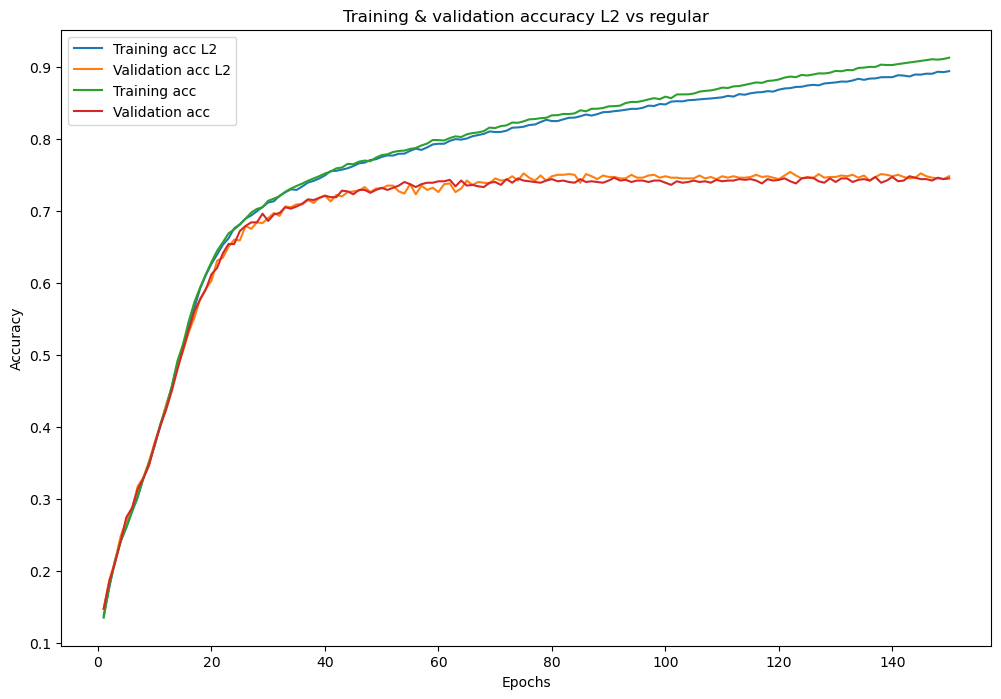

In [37]:
# L2 model details
L2_model_dict = L2_model_val.history
L2_acc_values = L2_model_dict['acc'] 
L2_val_acc_values = L2_model_dict['val_acc']

# Baseline model
baseline_model_acc = baseline_model_val_dict['acc'] 
baseline_model_val_acc = baseline_model_val_dict['val_acc']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, L2_acc_values, label='Training acc L2')
ax.plot(epochs, L2_val_acc_values, label='Validation acc L2')
ax.plot(epochs, baseline_model_acc, label='Training acc')
ax.plot(epochs, baseline_model_val_acc, label='Validation acc')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show();

The results of L2 regularization are quite disappointing here. Notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better.  


## L1 Regularization

Now have a look at L1 regularization. Will this work better? 

- Use 2 hidden layers with 50 units in the first and 25 in the second layer, both with `'relu'` activation functions 
- Add L1 regularization to both the hidden layers with 0.005 as the `lambda_coeff` 

In [38]:
random.seed(123)
L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,)))

# Add a hidden layer
L1_model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(7, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L1_model_val = L1_model.fit(X_train_tokens, 
                            y_train_lb, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150


c:\Users\user\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.1274 - loss: 16.1850 - val_acc: 0.1520 - val_loss: 15.6188
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.1665 - loss: 15.4244 - val_acc: 0.1850 - val_loss: 14.8766
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2174 - loss: 14.6853 - val_acc: 0.2170 - val_loss: 14.1561
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2400 - loss: 13.9737 - val_acc: 0.2570 - val_loss: 13.4550
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2672 - loss: 13.2722 - val_acc: 0.2780 - val_loss: 12.7733
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2871 - loss: 12.5972 - val_acc: 0.2850 - val_loss: 12.1104
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3036 - loss: 11.9407 - val_acc: 0.3040 - val_loss: 11.4667
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3310 - loss: 11.2990 - val_acc: 0.3300 - val_loss: 10.8428
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0

Plot the training as well as the validation accuracy for the L1 model: 

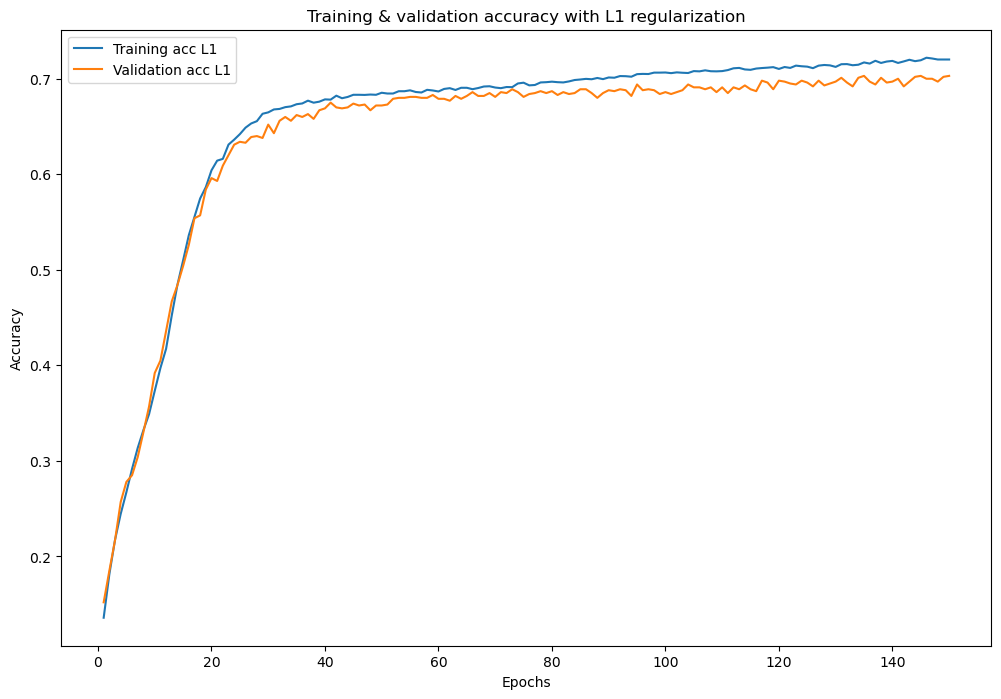

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model_val.history

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show();

Notice how the training and validation accuracy don't diverge as much as before. Unfortunately, the validation accuracy isn't still that good. Next, experiment with dropout regularization to see if it offers any advantages. 


## Dropout Regularization 

It's time to try another technique: applying dropout to layers. As discussed in the earlier lesson, this involves setting a certain proportion of units in each layer to zero. In the following cell: 

- Apply a dropout rate of 30% to the input layer 
- Add a first hidden layer with 50 units and `'relu'` activation 
- Apply a dropout rate of 30% to the first hidden layer 
- Add a second hidden layer with 25 units and `'relu'` activation 
- Apply a dropout rate of 30% to the second hidden layer 


In [40]:
# ⏰ This cell may take about a minute to run
random.seed(123)
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(2000,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(50, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(25, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(7, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='SGD', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
dropout_model_val = dropout_model.fit(X_train_tokens, 
                                      y_train_lb, 
                                      epochs=150, 
                                      batch_size=256, 
                                      validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150


c:\Users\user\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\regularization\dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.1674 - loss: 1.9778 - val_acc: 0.1840 - val_loss: 1.9333
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.1653 - loss: 1.9519 - val_acc: 0.1870 - val_loss: 1.9215
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.1835 - loss: 1.9381 - val_acc: 0.1970 - val_loss: 1.9146
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.1848 - loss: 1.9318 - val_acc: 0.2090 - val_loss: 1.9085
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.1995 - loss: 1.9213 - val_acc: 0.2190 - val_loss: 1.9027
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.1984 - loss: 1.9142 - val_acc: 0.2220 - val_loss: 1.8963
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.1969 - loss: 1.9038 - val_acc: 0.2280 - val_loss: 1.8896
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2008 - loss: 1.9010 - val_acc: 0.2360 - val_loss: 1.8827
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2135 - loss: 

In [41]:
results_train = dropout_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = dropout_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}') 

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8123 - loss: 0.5589
Training Loss: 0.565 
Training Accuracy: 0.802
----------
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7735 - loss: 0.6135
Test Loss: 0.623 
Test Accuracy: 0.782


You can see here that the validation performance has improved again, and the training and test accuracy are very close!  

## Bigger Data? 

Finally, let's examine if we can improve the model's performance just by adding more data. We've quadrapled the sample dataset from 10,000 to 40,000 observations, and all you need to do is run the code! 

In [42]:
df_bigger_sample = df.sample(40000, random_state=123)

X = df['Consumer complaint narrative']
y = df['Product']

# Train-test split
X_train_bigger, X_test_bigger, y_train_bigger, y_test_bigger = train_test_split(X, 
                                                                                y, 
                                                                                test_size=6000, 
                                                                                random_state=42)

# Validation set
X_train_final_bigger, X_val_bigger, y_train_final_bigger, y_val_bigger = train_test_split(X_train_bigger, 
                                                                                          y_train_bigger, 
                                                                                          test_size=4000, 
                                                                                          random_state=42)


# One-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final_bigger)

X_train_tokens_bigger = tokenizer.texts_to_matrix(X_train_final_bigger, mode='binary')
X_val_tokens_bigger = tokenizer.texts_to_matrix(X_val_bigger, mode='binary')
X_test_tokens_bigger = tokenizer.texts_to_matrix(X_test_bigger, mode='binary')

# One-hot encoding of products
lb = LabelBinarizer()
lb.fit(y_train_final_bigger)

y_train_lb_bigger = to_categorical(lb.transform(y_train_final_bigger))[:, :, 1]
y_val_lb_bigger = to_categorical(lb.transform(y_val_bigger))[:, :, 1]
y_test_lb_bigger = to_categorical(lb.transform(y_test_bigger))[:, :, 1]

In [43]:
# ⏰ This cell may take several minutes to run
random.seed(123)
bigger_data_model = models.Sequential()
bigger_data_model.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
bigger_data_model.add(layers.Dense(25, activation='relu'))
bigger_data_model.add(layers.Dense(7, activation='softmax'))

bigger_data_model.compile(optimizer='SGD', 
                          loss='categorical_crossentropy', 
                          metrics=['acc'])

bigger_data_model_val = bigger_data_model.fit(X_train_tokens_bigger,  
                                              y_train_lb_bigger,  
                                              epochs=150,  
                                              batch_size=256,  
                                              validation_data=(X_val_tokens_bigger, y_val_lb_bigger))

c:\Users\user\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.1694 - loss: 1.9458 - val_acc: 0.2810 - val_loss: 1.8785
Epoch 2/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.3147 - loss: 1.8302 - val_acc: 0.4200 - val_loss: 1.6438
Epoch 3/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4689 - loss: 1.5468 - val_acc: 0.5692 - val_loss: 1.3068
Epoch 4/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6110 - loss: 1.2138 - val_acc: 0.6557 - val_loss: 1.0589
Epoch 5/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6748 - loss: 0.9976 - val_acc: 0.6913 - val_loss: 0.9102
Epoch 6/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.7036 - loss: 0.8627 - val_acc: 0.7153 - val_loss: 0.8206
Epoch 7/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7244 - loss: 0.7804 - val_acc: 0.7315 - val_loss: 0.7651
Epoch 8/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7384 - loss: 0.7299 - val_acc: 0.7385 - val_loss: 0.7278
Epoch 9/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

In [44]:
results_train = bigger_data_model.evaluate(X_train_tokens_bigger, y_train_lb_bigger)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = bigger_data_model.evaluate(X_val_tokens_bigger, y_val_lb_bigger)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9052 - loss: 0.2783
Training Loss: 0.282 
Training Accuracy: 0.904
----------
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8194 - loss: 0.5754
Test Loss: 0.601 
Test Accuracy: 0.809


With the same amount of epochs and no regularization technique, you were able to get both better test accuracy and loss. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance! 


## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database 


## Summary  

In this lesson, you built deep learning models using a validation set and used several techniques such as L2 and L1 regularization, dropout regularization, and early stopping to improve the accuracy of your models. 